# Task A

In this task, we had to create a "transform" function which transforms unperformed beats time into a performed version.

In other words, given the `midi_score_annotations.txt` and `NAME_annotations.txt`, we need to create a function that transfers first column of the first file into the first column of the second file.

For the velocity, we use `*.mid` files and extract velocity from events. "Beat velocity" is defined as an average of the velocities of the events close to this beat. Event is close to the beat iff the difference between its onset in score and beat time is smaller than `0.5`. Then we again create a "transform" function.

In [6]:
%load_ext autoreload
%autoreload 2

from src.data import *
from src.plots import *
from src.estimators import *
from src.onset_distribution import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df, json_data = get_dataset_metadata("Bach")

In [ ]:
df.head(100)

In [ ]:
# Code for random estimator
beats_list_dict = create_midi_performance_pairs(df, json_data, "4/4")
get_beat_indices(beats_list_dict["midi_beats_list"],beats_list_dict["midi_downbeats_list"], beats_list_dict["bpm_list"])

In [ ]:
# for the first time might take up to 7 min because of velocity
beats_list_dict = get_midi_performance_pairs(df, json_data)

In [ ]:
train_beats_list_dict, test_beats_list_dict = train_test_split(beats_list_dict, test_size=0.2)

In [ ]:
midi_beats_list = test_beats_list_dict["midi_beats_list"]
performance_beats_list = test_beats_list_dict["performance_beats_list"]
perf_velocity_beats_list = test_beats_list_dict["perf_velocity_beats_list"]

performance_beats_estimated_list_dict = {}
perf_velocity_beats_estimated_list_dict = {}

In [ ]:
# random estimate
performance_beats_estimated_list, velocity_beats_estimated_list = get_estimator_predictions(train_beats_list_dict,
                                                                                            test_beats_list_dict,
                                                                                            estimator_type="random")

performance_beats_estimated_list_dict["random"] = performance_beats_estimated_list
perf_velocity_beats_estimated_list_dict["random"] = velocity_beats_estimated_list

In [ ]:
# linear estimate
performance_beats_estimated_list, velocity_beats_estimated_list = get_estimator_predictions(train_beats_list_dict,
                                                                                            test_beats_list_dict,
                                                                                            estimator_type="linear")

performance_beats_estimated_list_dict["linear"] = performance_beats_estimated_list
perf_velocity_beats_estimated_list_dict["linear"] = velocity_beats_estimated_list

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0] = plot_average_transfer_function(axes[0], midi_beats_list,
                                        performance_beats_list,
                                        performance_beats_estimated_list_dict,
                                        performance_type="time"
)

axes[1] = plot_average_transfer_function(axes[1], midi_beats_list,
                                        perf_velocity_beats_list,
                                        perf_velocity_beats_estimated_list_dict,
                                        performance_type="velocity"
)

# Task B

Use `src.data.get_events_table_from_score`

Time signature (2, 2) is present in 4 pieces.


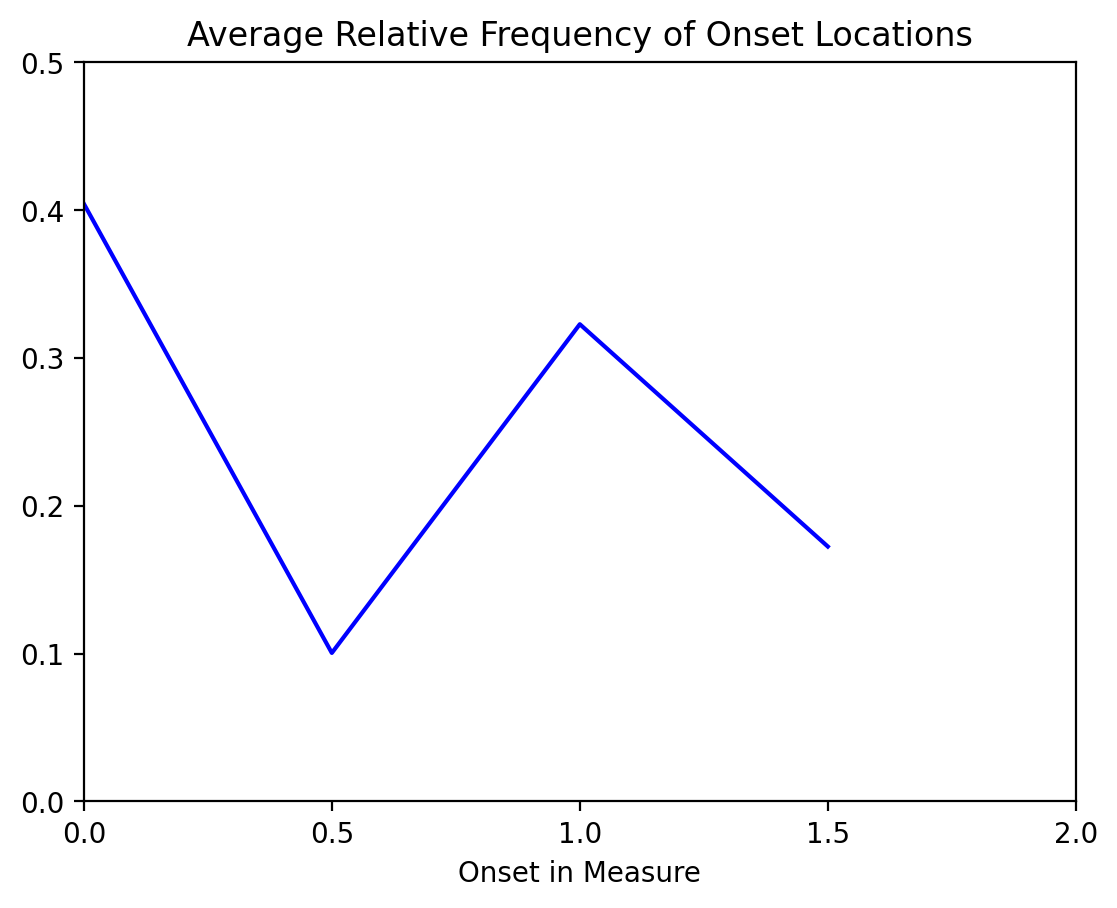

In [7]:
from pathlib import Path
# DATASET_PATH = Path("./data/asap-dataset")
# We analyse Bach's Fugues (or other?)
corpus = DATASET_PATH / "Bach" / "Fugue"

# get_average_distribution_given_time_signature(corpus, (3,4))
# get_average_distribution_given_time_signature(corpus, (4,4))
# get_average_distribution_given_time_signature(corpus, (3,8))
get_average_distribution_given_time_signature(corpus, (2,2))

In [8]:
import pandas as pd
from scipy.stats import levene

annotation_path = 'data/asap-dataset/Bach/Fugue/bwv_885/SINKEV06_annotations.txt'

def annotation_to_inter_onset_intervals(annotation_path: str):
    annotation = pd.read_table(annotation_path, header=None)
    ts = extract_time_signatures_from_annotation(annotation)
    onset, time_signature = ts[0]
    beats = time_signature[0]
    inter_onset_interval = calculate_inter_onset_intervals(annotation, beats)
    # skip prelude and always start on first downbeat
    interval = inter_onset_interval.iloc[onset:,].reset_index(drop=True)
    return interval

def get_interval_statistics(interval: pd.Series, beats:int) -> pd.DataFrame:
    '''
    Returns the mean and standard deviation of the inter-onset intervals for each beat 
    '''
    interval_statistics = pd.DataFrame(columns=['mean', 'std'])
    for i in range(beats):
        mask = interval.index % beats == i
        beat_timings = interval[mask]
        interval_statistics.loc[i] = [beat_timings.mean(), beat_timings.std()]
    return interval_statistics

def get_levene_test_results(interval: pd.Series, beats:int) -> tuple[float, float]:
    '''
    Performs a levene test to check if the variance of the inter-onset intervals is equal for all beats
    '''
    samples = []
    for i in range(beats):
        sample = interval[interval.index % beats == i]
        samples.append(sample)
    statistic, p_value = levene(*samples)
    return statistic, p_value


In [9]:
interval = annotation_to_inter_onset_intervals(annotation_path)
beats = extract_time_signatures_from_annotation(annotation_path)[0][1][0]


In [10]:
get_interval_statistics(interval, beats)

,mean,std
0,0.584274,0.107239
1,0.573006,0.084980
2,0.563146,0.081046


In [11]:
get_levene_test_results(interval, beats)

(0.2519995223235202, 0.7774471442957743)